### Applying the SAM2 Model to the JarLids dataset 
#### By: Madison Mina
Hopefully this works, crossing fingers :D

First we will download the dataset from Kaggle.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rrighart/jarlids")

print("Path to dataset files:", path)

/usr/local/miniforge/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4


Now let's change directory to make sure we can access the images from the dataset.

In [3]:
%cd /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4

/home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4


Okay now we will install the SAM2 Model!

In [4]:
!pip install ultralytics

Let's try SAM2 on an image from our dataset :D

In [5]:
from ultralytics import SAM

model = SAM("sam2.1_b.pt")

results = model("p1.JPG", save=True, imgsz=1024, task="segment")



image 1/1 /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4/p1.JPG: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 9884.4ms
Speed: 14.6ms preprocess, 9884.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4/runs/segment/predict7


In [6]:
cd runs/segment/predict6

/home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4/runs/segment/predict6


(-0.5, 639.5, 479.5, -0.5)

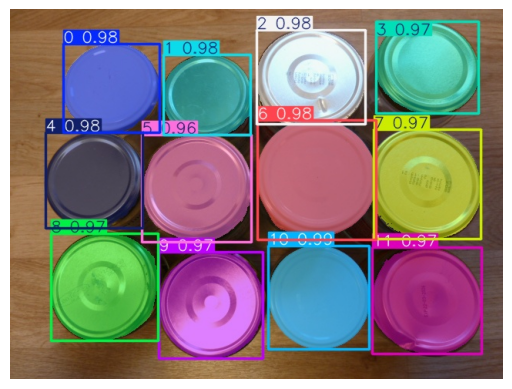

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("p1.jpg")

plt.imshow(img)
plt.axis("off")


Let's go back and look at our dataset :) It has helpful information about where the jars and defects are!

In [8]:
%cd /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4

/home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4


In [9]:
import pandas as pd
import json
import os

df = pd.read_csv("jarlids_annots.csv")
df

,Unnamed: 0,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,0,p1.JPG,167996,{},12,0,"{""name"":""rect"",""x"":70,""y"":46,""width"":120,""heig...","{""type"":""intact""}"
1,1,p1.JPG,167996,{},12,1,"{""name"":""rect"",""x"":195,""y"":60,""width"":118,""hei...","{""type"":""intact""}"
2,2,p1.JPG,167996,{},12,2,"{""name"":""rect"",""x"":318,""y"":25,""width"":144,""hei...","{""type"":""damaged""}"
3,3,p1.JPG,167996,{},12,3,"{""name"":""rect"",""x"":474,""y"":13,""width"":135,""hei...","{""type"":""intact""}"
4,4,p1.JPG,167996,{},12,4,"{""name"":""rect"",""x"":45,""y"":162,""width"":123,""hei...","{""type"":""intact""}"
...,...,...,...,...,...,...,...,...
1854,1854,t1.JPG,174414,{},6,1,"{""name"":""rect"",""x"":232,""y"":34,""width"":147,""hei...","{""type"":""intact""}"
1855,1855,t1.JPG,174414,{},6,2,"{""name"":""rect"",""x"":451,""y"":89,""width"":124,""hei...","{""type"":""intact""}"
1856,1856,t1.JPG,174414,{},6,3,"{""name"":""rect"",""x"":80,""y"":248,""width"":138,""hei...","{""type"":""damaged""}"
1857,1857,t1.JPG,174414,{},6,4,"{""name"":""rect"",""x"":244,""y"":284,""width"":146,""he...","{""type"":""intact""}"


With the information in 'region_shape_attributes' and 'region_attributes', lets form a red box around the defects and green around the intact jarlids!

In [14]:
from PIL import ImageDraw

save_dir = "runs/segment/overlays_single"
os.makedirs(save_dir, exist_ok=True)

one_image_df = df[df["filename"] == "p1.JPG"]

bboxes = []
labels = []

# Extract all bboxes + labels for p1.JPG
for _, row in one_image_df.iterrows():
    shape = json.loads(row["region_shape_attributes"])
    label = json.loads(row["region_attributes"])

    if shape["name"] == "rect":
        x = shape["x"]
        y = shape["y"]
        w = shape["width"]
        h = shape["height"]

        bboxes.append([x, y, x + w, y + h])
        labels.append(1 if label["type"] == "damaged" else 0)

print("Found", len(bboxes), "regions")

# Run the model on that image and pass all bounding boxes
results = model("p1.JPG", bboxes=bboxes, save=False)

# Load original image (RGBA for transparency)
img = Image.open("p1.JPG").convert("RGBA")
W, H = img.size

# Iterate through masks returned from the model
res = results[0]   # SAM returns a list; p1.JPG = 1 item
mask_list = res.masks.data.cpu().numpy()   # shape: [N, H, W]

print("Model returned masks:", mask_list.shape[0])

draw = ImageDraw.Draw(img, "RGBA")

# For each mask + bbox + label
for i in range(len(bboxes)):

    # correct mask index
    mask_array = mask_list[i]

    # Convert mask to a proper PIL mask
    mask_img = Image.fromarray((mask_array * 255).astype("uint8"), mode="L")

    # Choose overlay color
    color = (255, 0, 0, 100) if labels[i] == 1 else (0, 255, 0, 100)

    # Transparent layer
    overlay = Image.new("RGBA", (W, H), (0, 0, 0, 0))

    # Paste color using mask properly
    overlay_draw = ImageDraw.Draw(overlay)
    overlay_draw.bitmap((0, 0), mask_img, fill=color)

    # Composite mask onto base image
    img = Image.alpha_composite(img, overlay)

    # Draw bounding box
    box = bboxes[i]
    outline = "red" if labels[i] == 1 else "green"
    draw.rectangle(box, outline=outline, width=3)

# Save final result
output_path = os.path.join(save_dir, "p1.JPG")
img.convert("RGB").save(output_path)

print("Saved:", output_path)

Found 12 regions

image 1/1 /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4/p1.JPG: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 346.2ms
Speed: 17.5ms preprocess, 346.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)
Model returned masks: 12
Saved: runs/segment/overlays_single/p1.JPG


(-0.5, 639.5, 479.5, -0.5)

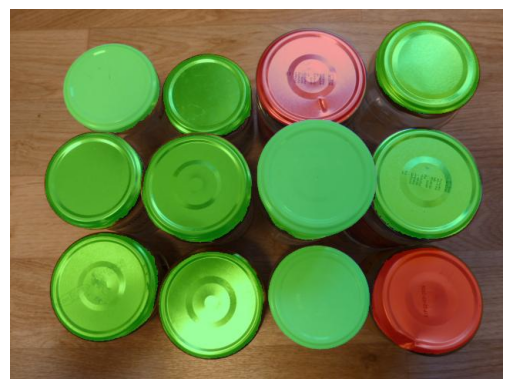

In [15]:
img = Image.open("runs/segment/overlays_single/p1.JPG")

plt.imshow(img)
plt.axis("off")


Now, we are going to run SAM on all the bounding boxes from the CSV region attributes and generate overlay masks on the original images to highlight defective areas.

In [16]:
from PIL import ImageDraw

# Directory to save masks
save_dir = "runs/segment/overlays"  # folder to save overlay images
os.makedirs(save_dir, exist_ok=True) 

# Group by filename
grouped = df.groupby('filename')

for filename, group in grouped:
    bboxes = []
    labels = []

    # Parse all regions for this image
    for _, row in group.iterrows():
        shape = json.loads(row["region_shape_attributes"])
        label = json.loads(row["region_attributes"])

        if shape["name"] == "rect":
            x = shape["x"]
            y = shape["y"]
            w = shape["width"]
            h = shape["height"]

            bboxes.append([x, y, x + w, y + h])
            labels.append(1 if label["type"] == "damaged" else 0)

    print("Found", len(bboxes), "bboxes")

    if len(bboxes) == 0:
        print("No rectangles → skipping")
        continue

    # Run SAM
    results = model(filename, bboxes=bboxes, save=False)
    res = results[0]              # only 1 image
    mask_list = res.masks.data.cpu().numpy()    # shape: [N, H, W]

    print("Model returned masks:", mask_list.shape[0])

    # Load image
    img = Image.open(filename).convert("RGBA")
    W, H = img.size
    draw = ImageDraw.Draw(img, "RGBA")

    # Draw each mask and bbox
    for i in range(len(bboxes)):

        # mask i
        mask_array = mask_list[i]
        mask_img = Image.fromarray((mask_array * 255).astype("uint8"), mode="L")

        # damaged=red, intact=green
        color = (255, 0, 0, 100) if labels[i] == 1 else (0, 255, 0, 100)

        # transparent overlay
        overlay = Image.new("RGBA", (W, H), (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)

        # draw mask properly
        overlay_draw.bitmap((0, 0), mask_img, fill=color)
        img = Image.alpha_composite(img, overlay)

        # draw bounding box
        outline = "red" if labels[i] == 1 else "green"
        draw.rectangle(bboxes[i], outline=outline, width=3)

    # Save output
    out_path = os.path.join(save_dir, os.path.basename(filename))
    img.convert("RGB").save(out_path)

    print(f"Saved → {out_path}")

print("\n🎉 ALL DONE! Check:", save_dir)


Found 12 bboxes

image 1/1 /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4/p1.JPG: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 379.9ms
Speed: 18.2ms preprocess, 379.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)
Model returned masks: 12
Saved → runs/segment/overlays/p1.JPG
Found 6 bboxes

image 1/1 /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4/p10.JPG: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 271.2ms
Speed: 9.2ms preprocess, 271.2ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)
Model returned masks: 6
Saved → runs/segment/overlays/p10.JPG
Found 10 bboxes

image 1/1 /home/ad.msoe.edu/minam/.cache/kagglehub/datasets/rrighart/jarlids/versions/4/p100.JPG: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 282.0ms
Speed: 4.9ms preprocess, 282.0ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)
Model returned masks: 10
Saved → runs/

Yay! Now we have our folder of overlays (boxes and heatmaps)\
It's time to see our final product ⸜(｡˃ ᵕ ˂ )⸝♡

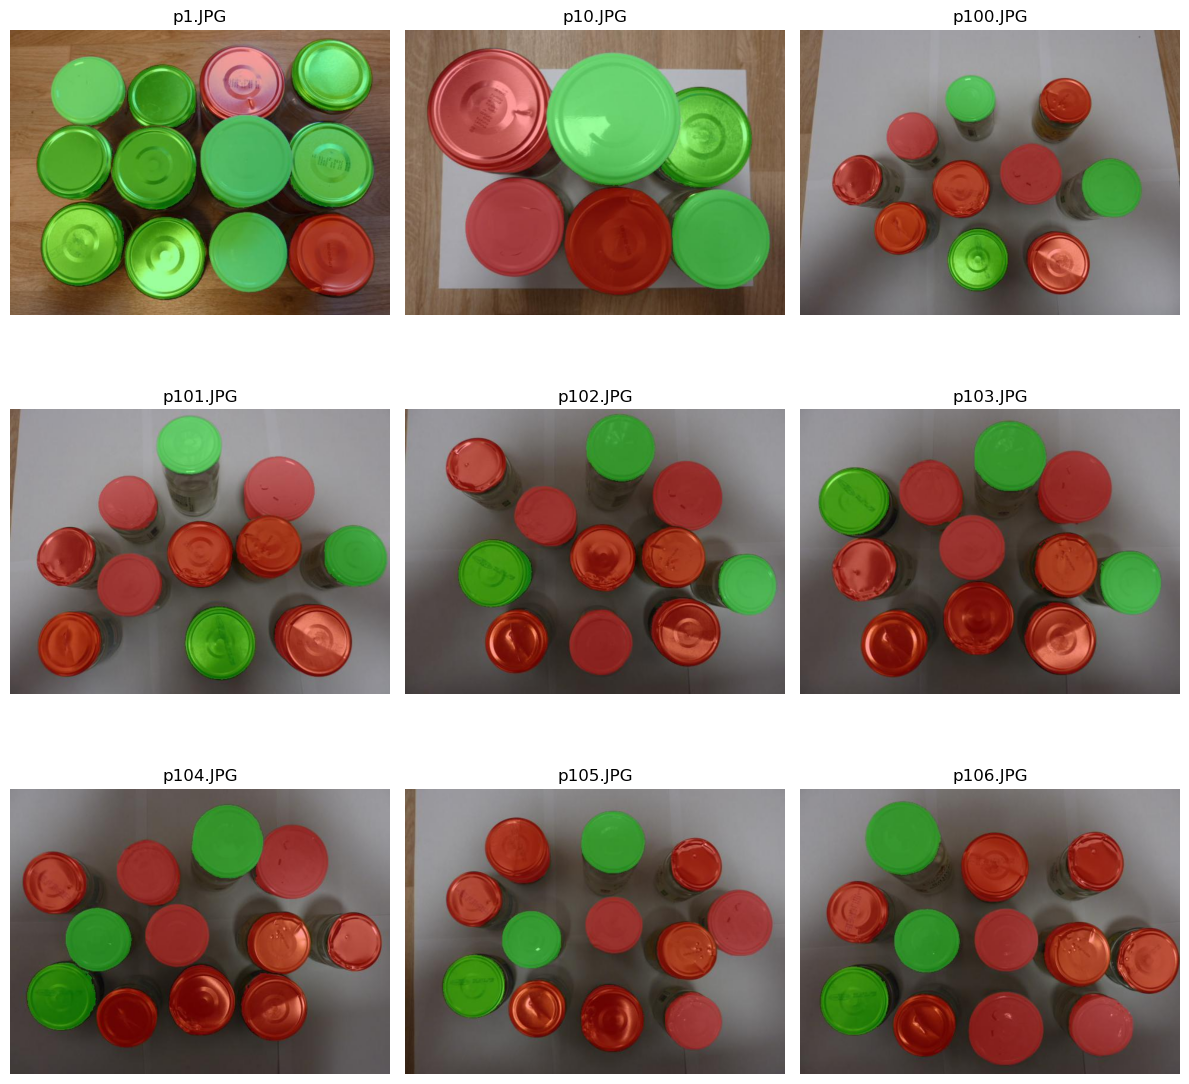

In [20]:
folder = "runs/segment/overlays"
files = sorted(os.listdir(folder))[:9]
plt.figure(figsize=(12, 12))

for i, fname in enumerate(files):
    img = Image.open(os.path.join(folder, fname))
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(fname)  # show the filename
    plt.axis("off")

plt.tight_layout()
plt.show()